## Bài 1

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
%%bash
base_dir="/content/drive/MyDrive/DL-TH2/"
touch "$base_dir/main.py"
touch "$base_dir/LeNet.py"
touch "$base_dir/mnist_dataset.py"

echo "Đã tạo 2 file rỗng trong $base_dir:"
ls -l "$base_dir"

Đã tạo 2 file rỗng trong /content/drive/MyDrive/DL-TH2/:
total 28
-rw------- 1 root root  2108 Oct 30 12:36 assignments.ipynb
-rw------- 1 root root 15711 Oct 30 17:54 Bai1.ipynb
-rw------- 1 root root  1622 Oct 30 17:54 LeNet.py
-rw------- 1 root root     0 Oct 30 17:54 main.py
drwx------ 2 root root  4096 Oct 15 10:36 mnist-dataset
-rw------- 1 root root     0 Oct 30 17:54 mnist_dataset.py
drwx------ 2 root root  4096 Oct 30 17:54 __pycache__


In [78]:
!pip install idx2numpy

In [79]:
!pip install torchvision

In [80]:
%%writefile "/content/drive/MyDrive/DL-TH2/mnist_dataset.py"
import torch
from torch.utils.data import Dataset
import idx2numpy
import numpy as np


def collate_fn(items: list[dict]) -> dict:
    """
    Gom nhiều item (dict) thành batch tensor.
    Input: list các dict {"image": np.array, "label": int}
    Output: dict {"image": Tensor, "label": Tensor}
    """
    images = [np.expand_dims(item["image"], axis=0) for item in items]
    labels = [item["label"] for item in items]

    images = np.stack(images, axis=0)
    labels = np.array(labels, dtype=np.int64)

    images = torch.tensor(images, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)

    return {"image": images, "label": labels}


class MnistDataset(Dataset):
    """
    Dataset đọc trực tiếp file MNIST dạng .idx
    Ví dụ:
      image_path = '/content/train-images.idx3-ubyte'
      label_path = '/content/train-labels.idx1-ubyte'
    """
    def __init__(self, image_path: str, label_path: str):
        images = idx2numpy.convert_from_file(image_path)
        labels = idx2numpy.convert_from_file(label_path)

        assert len(images) == len(labels), "Số lượng ảnh và nhãn không khớp!"
        self._data = [{
            "image": image.astype(np.float32) / 255.0,
            "label": int(label)
        } for image, label in zip(images, labels)]

    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self, idx: int) -> dict:
        return self._data[idx]

Overwriting /content/drive/MyDrive/DL-TH2/mnist_dataset.py


In [81]:
%%writefile /content/drive/MyDrive/DL-TH2/LeNet.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=5,
            stride=1,
            padding=2
        )

        # Layer 2: Pool1
        self.pooling_1 = nn.AvgPool2d(
            kernel_size=2,
            stride=2
        )

        # Layer 3: Conv2
        self.conv_2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=0
        )

        # Layer 4: Pool2
        self.pooling_2 = nn.AvgPool2d(
            kernel_size=2,
            stride=2
        )

        # Layer 5: Conv3
        self.conv_3 = nn.Conv2d(
            in_channels=16,
            out_channels=120,
            kernel_size=5,
            padding=0
        )

        # Layer 6: FC1
        self.fc = nn.Linear(
            in_features=120,
            out_features=84
        )

        # Layer 7: Outp
        self.output = nn.Linear(
            in_features=84,
            out_features=10
        )

    def forward(self, images: torch.Tensor):
        '''
        Input: images shape = (B, 1, 28, 28)
        Output: logits shape = (B, 10)
        '''

        x = F.relu(self.conv_1(images))
        x = self.pooling_1(x)

        x = F.relu(self.conv_2(x))
        x = self.pooling_2(x)

        x = F.relu(self.conv_3(x))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc(x))
        logits = self.output(x)
        return logits

Overwriting /content/drive/MyDrive/DL-TH2/LeNet.py


In [82]:
%%writefile /content/drive/MyDrive/DL-TH2/main.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import json

from LeNet import LeNet
from mnist_dataset import MnistDataset, collate_fn

device = "cuda" if torch.cuda.is_available() else "cpu"

def evaluate(dataloader: DataLoader, model: nn.Module) -> dict:
    model.eval()
    predictions, trues = [], []

    with torch.no_grad():
        for item in dataloader:
            image: torch.Tensor = item["image"].to(device)
            label: torch.Tensor = item["label"].to(device)

            output: torch.Tensor = model(image)
            output = torch.argmax(output, dim=1)

            predictions.extend(output.cpu().numpy())
            trues.extend(label.cpu().numpy())

    return {
        "precision": precision_score(trues, predictions, average="macro", zero_division=0),
        "accuracy": accuracy_score(trues, predictions),
        "f1": f1_score(trues, predictions, average="macro", zero_division=0)
    }

# Huan luyen
if __name__ == "__main__":
    train_dataset = MnistDataset(
        image_path="/content/drive/MyDrive/DL-TH2/mnist-dataset/train-images-idx3-ubyte",
        label_path="/content/drive/MyDrive/DL-TH2/mnist-dataset/train-labels-idx1-ubyte"
    )

    test_dataset = MnistDataset(
        image_path="/content/drive/MyDrive/DL-TH2/mnist-dataset/t10k-images-idx3-ubyte",
        label_path="/content/drive/MyDrive/DL-TH2/mnist-dataset/t10k-labels-idx1-ubyte"
    )

    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn
    )

    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=collate_fn
    )

    model = LeNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    EPOCH = 5
    best_score = 0
    best_metric = "f1"

    train_losses = []
    test_accuracies = []

    for epoch in range(EPOCH):
        model.train()
        epoch_loss = 0.0

        for item in train_dataloader:
            image: torch.Tensor = item["image"].to(device)
            label: torch.Tensor = item["label"].to(device)

            optimizer.zero_grad()
            output = model(image)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        metrics = evaluate(test_dataloader, model)
        avg_loss = epoch_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        test_accuracies.append(metrics["accuracy"])

        print(f"Epoch [{epoch+1}/{EPOCH}] "
              f"Loss: {avg_loss:.4f} "
              f"Acc: {metrics['accuracy']:.4f} "
              f"F1: {metrics['f1']:.4f}")

        if metrics[best_metric] > best_score:
            best_score = metrics[best_metric]
            torch.save(model.state_dict(), "/content/drive/MyDrive/DL-TH2/best_model.pth")
            print(f"Lưu mô hình tốt nhất tại epoch {epoch+1}")

    print("Đang lưu ")
    history_data = {
        "train_losses": train_losses,
        "test_accuracies": test_accuracies
    }

    with open("/content/drive/MyDrive/DL-TH2/training_history.json", "w") as f:
        json.dump(history_data, f)

    print("Đã lưu lịch sử vào 'training_history.json'")

Overwriting /content/drive/MyDrive/DL-TH2/main.py


In [83]:
!python /content/drive/MyDrive/DL-TH2/main.py

Epoch [1/5] Loss: 0.1805 Acc: 0.9722 F1: 0.9720
Lưu mô hình tốt nhất tại epoch 1
Epoch [2/5] Loss: 0.0948 Acc: 0.9814 F1: 0.9814
Lưu mô hình tốt nhất tại epoch 2
Epoch [3/5] Loss: 0.0860 Acc: 0.9821 F1: 0.9821
Lưu mô hình tốt nhất tại epoch 3
Epoch [4/5] Loss: 0.0789 Acc: 0.9824 F1: 0.9824
Lưu mô hình tốt nhất tại epoch 4
Epoch [5/5] Loss: 0.0747 Acc: 0.9843 F1: 0.9842
Lưu mô hình tốt nhất tại epoch 5
Đang lưu 
Đã lưu lịch sử vào 'training_history.json'


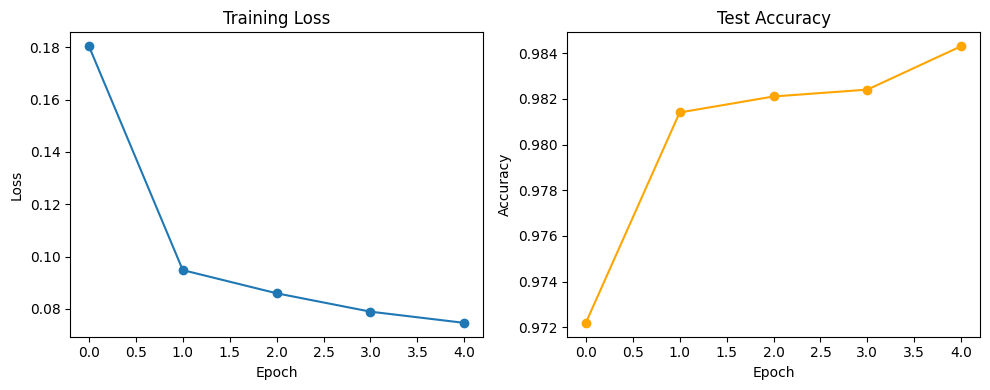

In [84]:
import json
import matplotlib.pyplot as plt

history_path = "/content/drive/MyDrive/DL-TH2/training_history.json"
try:
    with open(history_path, "r") as f:
        history = json.load(f)

    train_losses = history["train_losses"]
    test_accuracies = history["test_accuracies"]
    plt.figure(figsize=(10,4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, marker='o', color='orange')
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Lỗi")